# Logistic Regression From Scratch

***
## Table of Contents
1. Loading Data
2. Linear Regression
3. Loss Function (BCE)
4. Gradient Descent
5. Encapsulation
6. Prediction and Visualisation
7. Compare with Scikit-Learn
***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

## 1. Loading Data 

In [2]:
data_logistic = pd.read_csv("logistic_data.txt", header=None)
data_logistic.head()

,0,1,2
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
x_1 = np.array(data_logistic.iloc[:, 0])
x_2 = np.array(data_logistic.iloc[:, 1])
y = np.array(data_logistic.iloc[:, 2])

# Combine features into X with an added bias column (first column)
# X = np.c_[np.ones(x_1.shape[0]), x_1, x_2]
X = np.concatenate(
    (np.ones((x_1.shape[0], 1)),
     x_1[:, np.newaxis], x_2[:, np.newaxis]),
    axis=1
)
y = y[:, np.newaxis]  # Reshape y for matrix operations
X.shape, y.shape

((100, 3), (100, 1))

## 2. Logistic Regression
Logistic Regression is a machine learning algorithm commonly used for binary classification tasks or predicting the probability of a dicrete or categorical outcome. For binary classification, predictions are obtained by applying the sigmoid function, which takes a numerical independent variable as input and returns a value between 0 and 1. The sigmoid function is represented as:

\begin{align*}
S(z) = \dfrac{1}{1+e^{-z}}
\end{align*}

In [4]:
# Implement a sigmoid function
def sigmoid(z: np.array) -> np.array:
    return 1 / (1 + np.exp(-z))

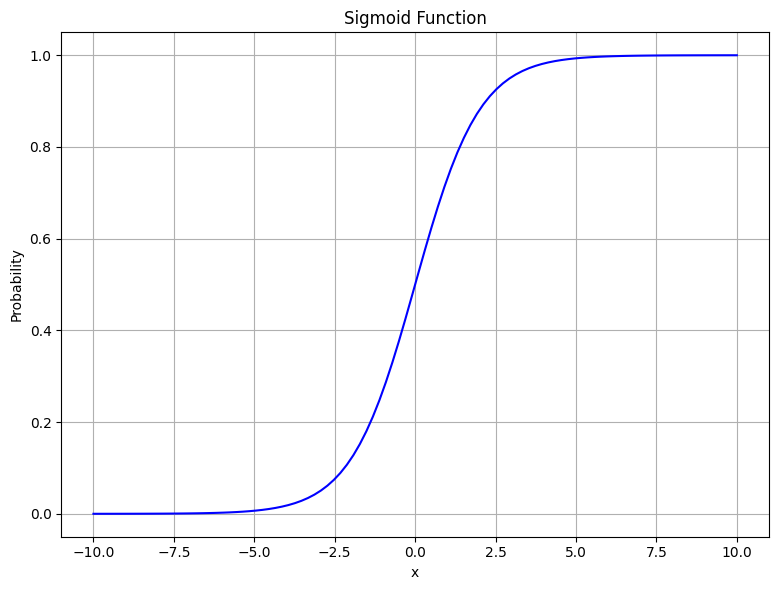

In [5]:
plt.figure(figsize=(8, 6))
x = np.linspace(-10, 10, 100)
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Sigmoid Function')
plt.grid(True)
plt.tight_layout()
plt.plot(x, sigmoid(x), color='blue')
plt.show()

The hypothesis function in logistic regression computers the linear combination of the feature matrix $X$ and the weight vector $W$, and then applies the sigmoid function to squash the output into a range between 0 and 1. Given a feature matrix $X$ and weight vector $W$, we can compute the predicted probabilities as follows:

\begin{align*}
z = X \cdot W = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_n x_n
\end{align*}

where $w_0$ is the bias and $w_1$, $w_2$, ..., $w_1$ are the weights for the features.

For example, suppose we have the following matrices:

\begin{align*}
&X = \begin{bmatrix} 1 & 2 \\ 1 & 3 \\ 1 & 4 \end{bmatrix} \\
&W = \begin{bmatrix} -1 \\ 0.5 \end{bmatrix}
\end{align*}

The linear combination $z$ for each sample in $X$ is calculated as:
\begin{align*}
z = X \cdot W = \begin{bmatrix} 1 & 2 \\ 1 & 3 \\ 1 & 4 \end{bmatrix} \cdot \begin{bmatrix} -1 \\ 0.5 \end{bmatrix} = \begin{bmatrix} 0 \\ 0.5 \\ 1 \end{bmatrix}
\end{align*}


Applying the sigmoid function to $z$ yields the predicted probabilities:

\begin{align*}
h(X) = \sigma (z) = \begin{bmatrix} \dfrac{1}{1+e^{0}} \\ \dfrac{1}{1+e^{-0.5}} \\ \dfrac{1}{1+e^{-1}} \end{bmatrix} \thickapprox \begin{bmatrix} 0.5 \\ 0.622 \\ 0.731 \end{bmatrix}
\end{align*}

In [6]:
# Hypothesis function with sigmoid activation
def hypothesis(X: np.array, W: np.array) -> np.array:
    return sigmoid(np.dot(X, W))

In [7]:
X_example = np.array([[1, 2],
                      [1, 3],
                      [1, 4]])
W_example = np.array([-1,
                      0.5])
print(
    f"Probabilities for each sample: {np.around(hypothesis(X_example, W_example), 3)}")

Probabilities for each sample: [0.5   0.622 0.731]


## 3. Loss Function (BCE)
In logistic regression, the Binary Cross-Entropy loss function is used to measure the error between the true labels $y$ and the predicted probabilities $\hat y$. The loss function is defined as:

\begin{align*}
L = - \dfrac{1}{n} \sum_{i=1}^{n} y_{i} \log(\hat y_{i}) + (1-y_{i}) \log(1- \hat y_{i})
\end{align*}

In [8]:
# Binary cross-entropy loss function
def calculate_loss_BCE(y: np.array, y_pred: np.array, n: int) -> float:
    return - (1 / n) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

## 4. Gradient Descent
Before computing the optimised weights using gradient descent, we need to calculate the partial derivatives of the binary cross entrophy with respect to the weights $W$. The gradient of the loss function is given by:

\begin{align*}
\dfrac{\partial L}{\partial W} = \dfrac{1}{n} (\hat y - y) \cdot X^{T}
\end{align*}

* $n$ is the number of samples in the dataset.
* $y$ is the actual value.
* $\hat y$ is the predicted value.
* $X^{T}$ is the transpose of the feature matrix $X$.

In [9]:
# Derivative of cost function L
def derivative_BCE(X: np.array, y: np.array, y_pred: np.array, n: int) -> float:
    dL_dW: float = (1/n) * np.dot(X.T, (y_pred - y))
    return dL_dW

We update the weights in each epoch of gradient descent to optimise the weights $W$ with the learning rate $\alpha$ as follows:

\begin{align*}
W = W - \alpha \cdot \dfrac{\partial L}{\partial W}
\end{align*}

By iteratively applying this update rule, the model minimise the binary cross-entropy loss and improves its predictions over epoch.


In [10]:
# Gradient descent for logistic regression
def gradient_descent(X: np.array, y: np.array, W: np.array,
                     alpha: float, epochs: int, n: int) -> tuple[np.array, np.array]:
    loss: list[float] = []
    for epoch in range(epochs):
        y_pred: np.array = hypothesis(X, W)
        dL_dW: float = derivative_BCE(X, y, y_pred, n)
        W -= alpha * dL_dW
        loss.append(calculate_loss_BCE(y, y_pred, n))
    return W, np.array(loss)

Let's initialise the weight vector $W$ with arbitrary values and execute `gradient_descent()` using a learning rate $\alpha$ of 0.001 for 5000 epochs.

In [11]:
# Initialise weights and hyperparameteres
W = np.array([-10, 0.2, 0.2])[:, np.newaxis]
alpha = 0.001
epochs = 5000
n = len(y)

# Calculate the optimised weights W and the loss of BCE
W_optimised, loss_BCE = gradient_descent(
    X, y, W, alpha, epochs, n)
print(f"Optimised weights after {epochs} epochs:\n {W}")

Optimised weights after 5000 epochs:
 [[-10.07002079]
 [  0.08601621]
 [  0.07977089]]


As the training progresses, we can observe a consistent decrease in the loss value over the epochs. This indicates that the model is learning by minimising the error, the difference between the predicted and actual values. 

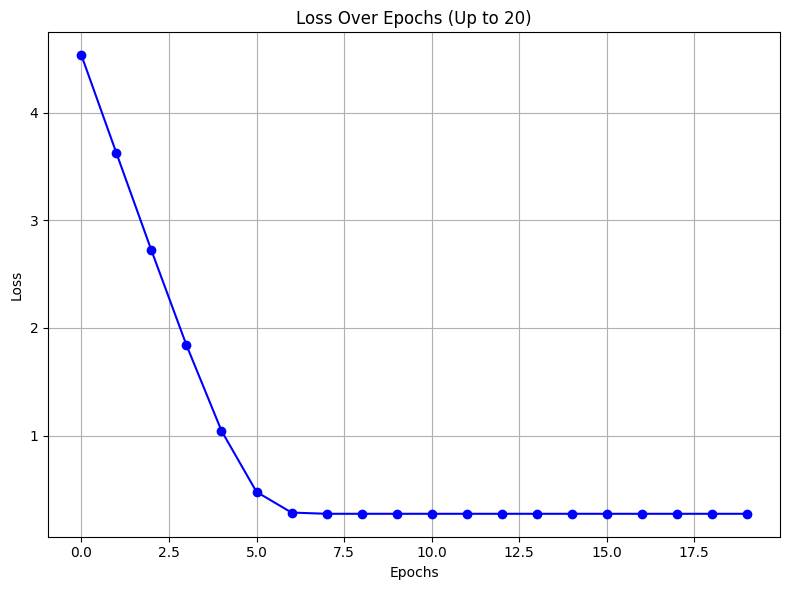

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(loss_BCE[:20], marker='o', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs (Up to 20)')
plt.tight_layout()
plt.grid(True)
plt.show()

## 5. Accuracy

Now, we visualise the data to illustrate how the logistic regression model classifies the data and separates the classes using a decision boundary. The decision boundary is a linear function derived from the model's hypothesis that separates the input space into two distinct regions. Typically, it represents the set of points where the model predicts a probability of 50%. 

We compute the model's predictions using the optimised weight vector `W_optimised`. If the predicted probability is greater than or equal to 0.5, the data point is classified as 1; otherwise it is classify as 0. For instance, given $y_{pred} = [0.85,0.15,0.65,0.30]$, the result would be $[1, 0, 1, 0]$. By calculating these predictions, we can also compute the accuracy to evaluate the model's performance.

In [13]:
# Make predictions and calculate accuracy
threshold = 0.5
y_pred = hypothesis(X, W_optimised)
y_pred_labels = (y_pred >= threshold).astype(int)
print(f"Accuracy: {np.mean(y_pred_labels == y) * 100:.2f}%")

Accuracy: 91.00%


In [14]:
# Draw a decision boundary (linear) at threshold = 0.5
def draw_decision_boundary(W: np.array, x_1: np.array) -> np.array:
    return -(W[0] + W[1] * x_1) / (W[2])

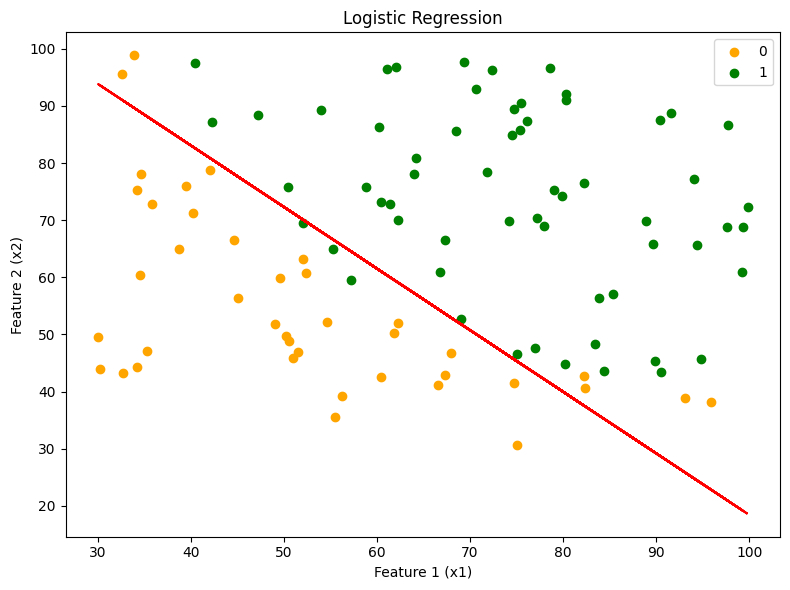

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(x=x_1[y.flatten() == 0],
            y=x_2[y.flatten() == 0], label='0', color='orange')
plt.scatter(x=x_1[y.flatten() == 1],
            y=x_2[y.flatten() == 1], label='1', color='green')
plt.plot(x_1, draw_decision_boundary(W, x_1), color="red")
plt.xlabel('Feature 1 (x1)')
plt.ylabel('Feature 2 (x2)')
plt.title('Logistic Regression')
plt.tight_layout()
plt.legend()
plt.show()

Finally, let's scale all the values in $X$ to a range between -10 and 10. This scaling helps to align the feature values with the sigmoid function's output range, which makes it easier to visualise the relationship between the features and their corresponding predictions. After scaling, we will create a plot to demonstrate the logistic regression model's behaviour.

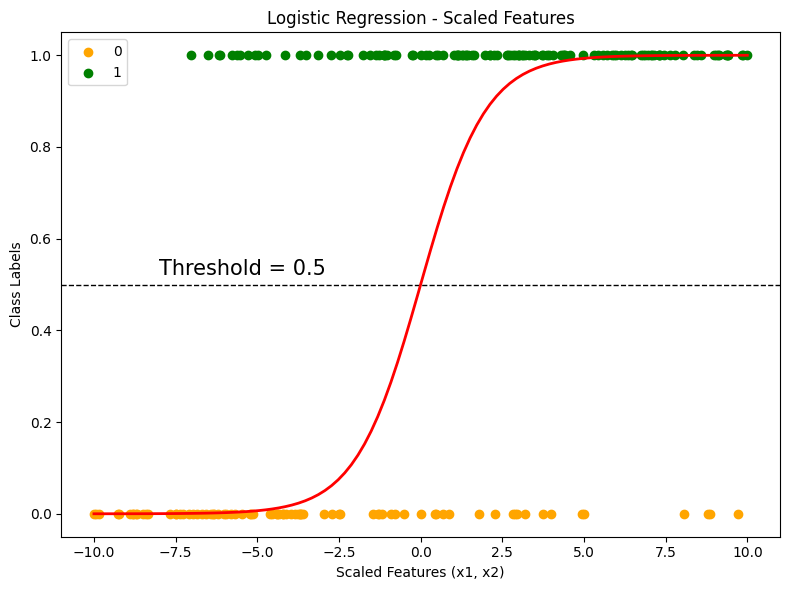

In [16]:
# Min-Max Scaling function
def scaler_func(values, original_min, original_max, new_min, new_max):
    return (values - original_min) * (new_max - new_min) / (original_max - original_min) + new_min


# Original range
og_min, og_max = np.min([np.min(x_1), np.min(x_2)]), np.max(
    [np.max(x_1), np.max(x_2)])

# Desired range
new_min, new_max = -10, 10

# Scale x_1_lgs and x_2_lgs
x_1_lgs_scaled = scaler_func(x_1, og_min, og_max, new_min, new_max)
x_2_lgs_scaled = scaler_func(x_2, og_min, og_max, new_min, new_max)

# Plot scaled data
plt.figure(figsize=(8, 6))
plt.scatter(x=x_1_lgs_scaled[y.flatten() == 0],
            y=y[y.flatten() == 0], label='0', color='orange')
plt.scatter(x=x_2_lgs_scaled[y.flatten() == 0],
            y=y[y.flatten() == 0], color='orange')
plt.scatter(x=x_1_lgs_scaled[y.flatten() == 1],
            y=y[y.flatten() == 1], label='1', color='green')
plt.scatter(x=x_2_lgs_scaled[y.flatten() == 1],
            y=y[y.flatten() == 1], color='green')

# Create a threshold line (cutoff) at y = 0.5
x = np.linspace(-10, 10, 100)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.text(x=-8, y=0.52, s='Threshold = 0.5', color='black', fontsize=15)

# Draw a sigmoid function
plt.plot(x, sigmoid(x), color='red', linewidth=2)

# Customise plot
plt.xlabel('Scaled Features (x1, x2)')
plt.ylabel('Class Labels')
plt.title('Logistic Regression - Scaled Features')
plt.tight_layout()
plt.legend()
plt.show()

## 6. Encapsulation
In practice, it is generally better to refactor these functions into a class-based implementation (encapsulation). It allows related functionalities to be grouped together, making the code more readable, reusable and easier to maintain. Let's encapsulate the functions above into a `CustomLogisticRegression` class, including the visualisations.

In [17]:
class CustomLogisticRegression:
    """
    Logistic Regression model using gradient descent.
    """

    def __init__(self, W, alpha: float = 0.01,
                 epochs: int = 5000, threshold: float = 0.5):
        """
        Initialise the model with weights given hyperparameters.

        Args:
        W (np.array): Initial weights, including bias term.
        alpha (float): Learning rate. Default = 0.01
        epochs (int): Number of iterations for gradient descent. Default = 5000.
        threshold (float): Classification threshold for predicting labels. Default = 0.5.
        """
        self.W = W
        self.alpha = alpha
        self.threshold = threshold
        self.epochs = epochs
        self.loss_history = []

    def sigmoid(self, z: np.array) -> np.array:
        """
        Compute the sigmoid function.

        Args:
            z (np.array): Input array, a linear combination of X(features) and W(weights).

        Returns:
            np.array: Output after applying the sigmoid function.
        """
        return 1 / (1 + np.exp(-z))

    def hypothesis(self, X: np.array) -> np.array:
        """
        Compute the hypothesis function for logistic regression.

        Args:
            X (np.array): Feature matrix.

        Returns:
            np.array: Predicted probabilities.
        """
        return sigmoid(np.dot(X, self.W))

    def calculate_loss_BCE(self, y: np.array, y_pred: np.array) -> float:
        """
        Calculate the Binary Cross-Entropy (BCE) loss.

        Args:
            y (np.array): True labels.
            y_pred (np.array): Predicted probabilities.

        Returns:
            float: BCE loss.
        """
        return - (1 / len(y)) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    def gradient_descent(self, X: np.array, y: np.array,) -> tuple[np.array, np.array]:
        """
        Perform gradient descent to optimize weights.

        Args:
            X (np.array): Feature matrix.
            y (np.array): True labels.
        """
        for epoch in range(self.epochs):
            y_pred: np.array = self.hypothesis(X)
            loss = self.calculate_loss_BCE(y, y_pred)
            self.loss_history.append(loss)
            dL_dW: float = (1/len(y)) * np.dot(X.T, (y_pred - y))
            self.W -= self.alpha * dL_dW

    def train(self, x: np.array, y: np.array) -> None:
        """
        Train the model using gradient descent.

        Args:
            X (np.array): Feature matrix.
            y (np.array): True labels.
        """
        self.gradient_descent(x, y)
        print(
            f"Training completed. Optimised weights:\n {self.W}")

    def calculate_accuracy(self, y_pred: np.array, y: np.array) -> float:
        """
        Calculate the accuracy of the model.

        Args:
            y_pred (np.array): Predicted labels.
            y (np.array): True labels.

        Returns:
            float: Accuracy percentage.
        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y) * 100

    def predict_proba(self, X: np.array) -> np.array:
        """
        Predict probabilities for the input data.

        Args:
            X (np.array): Feature matrix.

        Returns:
            np.array: Predicted probabilities.
        """
        return self.hypothesis(X)

    def predict(self, X: np.array) -> np.array:
        """
        Predict class labels based on the threshold.

        Args:
            X (np.array): Feature matrix.

        Returns:
            np.array: Predicted labels (0 or 1).
        """
        return (self.predict_proba(X) >= self.threshold).astype(int)

    def plot_loss_history(self) -> None:
        """
        Plot the loss history for the training process.
        """
        plt.figure(figsize=(8, 5))
        plt.plot(self.loss_history[:20], marker='o', color='b')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Over Epochs (Up to 20)')
        plt.grid(True)
        plt.show()

    def draw_decision_boundary(self, x_1: np.array, x_2: np.array,
                               y: np.array, sample_data=None) -> None:
        """
        Visualise the decision boundary of the logistic regression model.

        Args:
            x_1 (np.array): Feature 1 values.
            x_2 (np.array): Feature 2 values.
            y (np.array): True labels.
            sample_data (np.array, optional): A single sample for visualisation. Default is None.
        """
        decision_boundary = -(self.W[0] + self.W[1] * x_1) / self.W[2]
        plt.figure(figsize=(8, 6))
        plt.scatter(x=x_1[y.flatten() == 0], y=x_2[y.flatten()
                    == 0], label='0', color='orange')
        plt.scatter(x=x_1[y.flatten() == 1], y=x_2[y.flatten()
                    == 1], label='1', color='green')
        plt.plot(x_1, decision_boundary, color="red",
                 label="Decision Boundary")

        if sample_data is not None:
            test_x1, test_x2 = sample_data[0, 1], sample_data[0, 2]
            test_label = self.predict(sample_data)
            color = 'blue' if test_label == 0 else 'purple'
            plt.scatter(test_x1, test_x2, label='Test Point',
                        color=color, edgecolor="black", zorder=2, s=100)

        plt.xlabel('Feature 1 (x1)')
        plt.ylabel('Feature 2 (x2)')
        plt.title('Logistic Regression Decision Boundary')
        plt.legend()
        plt.tight_layout()
        plt.show()

Training completed. Optimised weights:
 [[-10.07002079]
 [  0.08601621]
 [  0.07977089]]


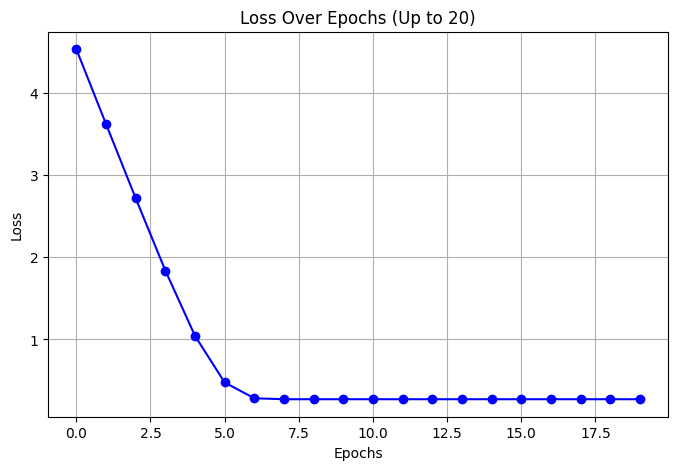

In [18]:
# Initialise weights
W = np.array([-10, 0.2, 0.2])[:, np.newaxis]

# Calculate the optimised weights W and the loss of BCE
model = CustomLogisticRegression(W=W, alpha=0.001, epochs=5000)
model.train(X, y)
model.plot_loss_history()

## 7. Prediction and Visualisation

Given $W=[1, 72, 52]$, below are the prediction, accuracy and correspoding visualisation:

In [19]:
test_W = np.array([1, 72, 52])[np.newaxis, :]  # [bias, x_1, x_2]
predicted_probability = model.predict_proba(test_W)
predicted_label = model.predict(test_W)
print(
    f"Predicted probability for the test sample: {predicted_probability[0, 0]:.5f}")
print(f"Predicted label for the test sample: {predicted_label[0, 0]}")

Predicted probability for the test sample: 0.56740
Predicted label for the test sample: 1


In [20]:
y_pred = model.predict(X)
print(f"Accuracy: {model.calculate_accuracy(y_pred, y):.2f}%")

Accuracy: 91.00%


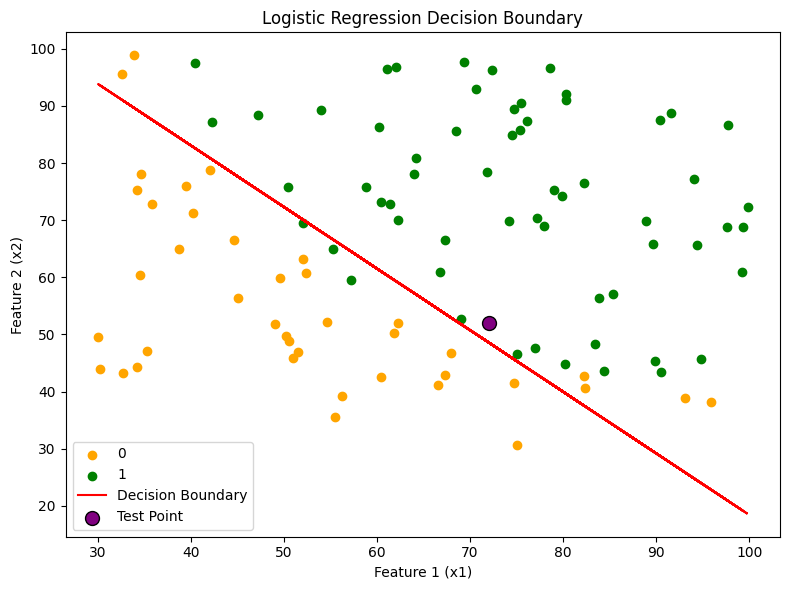

In [21]:
model.draw_decision_boundary(x_1, x_2, y, test_W)

## 8. Compare with Scikit-Learn

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

In [23]:
# Flatten the labels for scikit-learn compatibility
y_sk = y.ravel()

# Initialize and fit the logistic regression model
model_sk = LogisticRegression(max_iter=5000)
model_sk.fit(X, y_sk)

# Extract optimized weights and intercept
weights = model_sk.coef_  # Coefficients for features
intercept = model_sk.intercept_  # Intercept term
print("Optimized Weights:", weights)
print("Intercept:", intercept)

# Ensure test_W is compatible with the number of features in X
if test_W.shape[1] != X.shape[1]:
    raise ValueError("The number of features in test_W must match X.")

# Predict class labels for test_W
y_pred_sk = model_sk.predict(test_W)
print("Predicted Labels:", y_pred_sk)

# Predict probabilities for test_W
y_pred_proba_sk = model_sk.predict_proba(test_W)
print("Predicted Probabilities:", y_pred_proba_sk)

# Calculate log-loss for training data
y_pred_proba_train = model_sk.predict_proba(X)
loss_sk = log_loss(y_sk, y_pred_proba_train)
print("Log-Loss:", loss_sk)

# Calculate accuracy for training data
y_pred_train = model_sk.predict(X)
accuracy_sk = accuracy_score(y_sk, y_pred_train)
print(f"Accuracy: {accuracy_sk}%")

Optimized Weights: [[5.35039828e-07 2.05354457e-01 2.00583564e-01]]
Intercept: [-25.05214903]
Predicted Labels: [1]
Predicted Probabilities: [[0.45916173 0.54083827]]
Log-Loss: 0.20349948960278566
Accuracy: 0.89%


There are subtle differences between the custom implementation and the scikit-learn version of logistic regression. These differences arise from several factors, including the initialisation of weights, the convergence method used, and the application of regularisation.